In [1]:
import os
os.chdir('../src')

from molecular_cloud_initialization import *
from plotters import *
from cluster_cloud_initialization import *


import numpy as np
import matplotlib.pyplot as plt
from amuse.community.fi.interface import Fi
from amuse.lab import Particles, nbody_system
from amuse.couple import bridge
from amuse.units import units
from amuse.community.bhtree.interface import Bhtree
from amuse.ext.sink import new_sink_particles



In [2]:
tot_cloud_mass = 4/3 *units.constants.pi * (50 | units.pc)**3 * ( 2.3 | units.amu * 85 / (units.cm**3))
print(tot_cloud_mass.value_in(units.MSun))

#Assmuing a pure molecular hydrogen cloud, with typical density around 85 molecules per cm^-3, calculate the approximate cloud mass based on
#cloud size. 50 pc is selected for a small GC of only 100 stars. 

2510896.01674


In [3]:
# initialise and evolve the MC particle set
particles_cloud, converter_cloud  = make_molecular_cloud(N_cloud = 3_000_000,
                                                         M_cloud = 2_000_000 | units.MSun,
                                                         R_cloud = 50 | units.pc,
                                                         seed = 1312)

particles_cloud, density_map = evolve_molecular_cloud(particles_cloud, 
                                         converter_cloud, 
                                         t_end = 2 | units.Myr, 
                                         dt = 0.2 | units.Myr, 
                                         seed = 1312)

In [3]:
def hydro_code(Code, dt, converter, particles, seed):
    '''
    This function contains the parameters we want to initialise the 
    hydro code with. (hard Coded)
    '''
    
    np.random.seed(seed)

    hydro = Code(converter)
    hydro.parameters.use_hydro_flag = True # Hydrodynamics flag. True means:
                            # SPH hydro included, False means: gravity only.
    hydro.parameters.gamma = 1 # gas polytropic index (1.6666667)
                        # (default value:1.6666667). In this case-> Ideal Gas   
    hydro.parameters.timestep = dt
    hydro.parameters.eps_is_h_flag = True # Default value
    hydro.parameters.radiation_flag = False # turns off radiatiative cooling/heat.
    hydro.parameters.isothermal_flag = True  # Isothermal flag. True means:
                # isothermal gas (requires integrate_entropy_flag == False)
    hydro.parameters.integrate_entropy_flag = False #True means: integrate
                                          # entropy, else: internal energy. 
    hydro.gas_particles.add_particles(particles) # add the particles
   
    return hydro    

In [4]:
np.mean(particles_cloud.density)

quantity<1.61210299565e-19 m**-3 * kg>

In [5]:
# initialise the star particle set
star = Particles(1)
star.name = "star"
star.mass = 500 |units.MSun
star.radius = 0.25 | units.pc
star.position = (-1.0, 0, 0) * (12 | units.pc)
# star.velocity = (1.0, 0, 0) * (vorb.in_(units.kms))
star.velocity = (1.0, 0, 0) * (3| units.kms)

initial_mass = 500 |units.MSun
converter_star = nbody_system.nbody_to_si(star.mass.sum(), 
                                   star.position.sum())

In [6]:
#initiate the gravity code with sink particles
gravity_code = Bhtree(converter_star)
sink = new_sink_particles(star)

gravity_code.particles.add_particles(sink)

In [7]:
# #start the hydro code for the gas
hydro_cloud = hydro_code(Code = Fi, dt = 0.1 | units.Myr,
                         converter = converter_cloud,
                         particles = particles_cloud,
                         seed = 1312)


channel = {"to_sink": gravity_code.particles.new_channel_to(sink),
           "from_sink": sink.new_channel_to(gravity_code.particles),
           "to_cloud": hydro_cloud.gas_particles.new_channel_to(particles_cloud),
            "from_cloud": particles_cloud.new_channel_to(hydro_cloud.gas_particles)}



In [8]:
gravhydrobridge = bridge.Bridge(use_threading = False)
gravhydrobridge.add_system(gravity_code, (hydro_cloud,) )
gravhydrobridge.add_system(hydro_cloud, (gravity_code,) )
gravhydrobridge.timestep = 0.1 | units.Myr

In [24]:
# def sound_speed(temp,mean_molecular_mass):
#     temp = temp | units.K
#     k = units.constants.kB
#     molecular_weight = mean_molecular_mass | units.amu
#     sound_speed =(k*temp/molecular_weight).sqrt()

#     return sound_speed
    
    
def bondi_radius(stellar_mass):
    sound_speed = 0.2 | units.kms
    R = 2 * units.constants.G * stellar_mass /(sound_speed **2)

    return R

def bondi_accretion_rate(rho,v,r):
    dM = units.constants.pi * (r**2) * rho * v

    return dM


def hydro_sink_particles(sinks, bodies):
    all_lost_particles = Particles()
    for s in sinks:
        xs,ys,zs=s.x,s.y,s.z
        radius_squared = s.radius**2
        insink=bodies.select_array(lambda x,y,z: (x-xs)**2+(y-ys)**2+(z-zs)**2 < radius_squared,['x','y','z'])  
        if len(insink)==0:
            return insink

        cm=s.position*s.mass
        p=s.velocity*s.mass
        s.mass+=insink.total_mass()
        s.position=(cm+insink.center_of_mass()*insink.total_mass())/s.mass
        s.velocity=(p+insink.total_momentum())/s.mass
        all_lost_particles.add_particles(insink)
    return all_lost_particles


In [10]:
print(sink.mass[0]-initial_mass)

0.0 MSun


In [26]:
print((bondi_radius(0.5 | units.MSun)).value_in(units.pc))

0.107550194633


In [11]:
print(len(particles_cloud.mass))
print(particles_cloud.mass.sum().value_in(units.MSun))
print(sink.mass)

965
10000.0
[500.0] MSun


In [12]:
print(sink)

                 key           lx           ly           lz         mass         name       radius  sink_radius           vx           vy           vz            x            y            z
                   -  g * m**2 / s  g * m**2 / s  g * m**2 / s         MSun         none       parsec       parsec  1000.0 * m * s**-1  1000.0 * m * s**-1  1000.0 * m * s**-1  3.08567758128e+16 * m  3.08567758128e+16 * m  3.08567758128e+16 * m
====================  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========
13589953609699492553    0.000e+00    0.000e+00    0.000e+00    5.000e+02         star    2.500e-01    2.500e-01    3.000e+00    0.000e+00    0.000e+00   -1.200e+01    0.000e+00    0.000e+00
====================  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ========

pre channel 500.0 MSun
post channel 500.0 MSun
Sink in progress at 0.5  Myr
93.2642487047 MSun
956 number of cloud particles now
post accretion 593.264248705 MSun


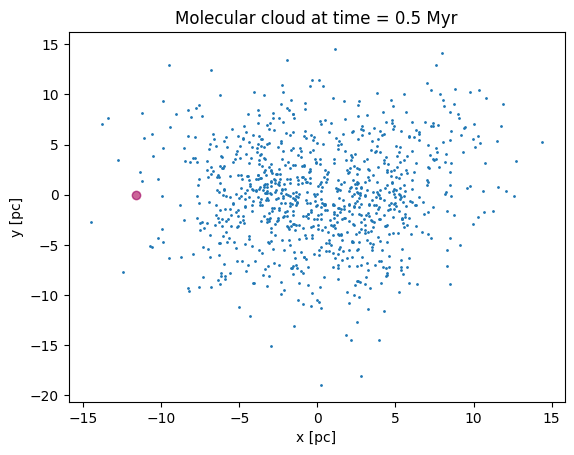

pre channel 593.264248705 MSun
post channel 593.264248705 MSun
Sink in progress at 1.0  Myr
103.626943005 MSun
955 number of cloud particles now
post accretion 603.626943005 MSun


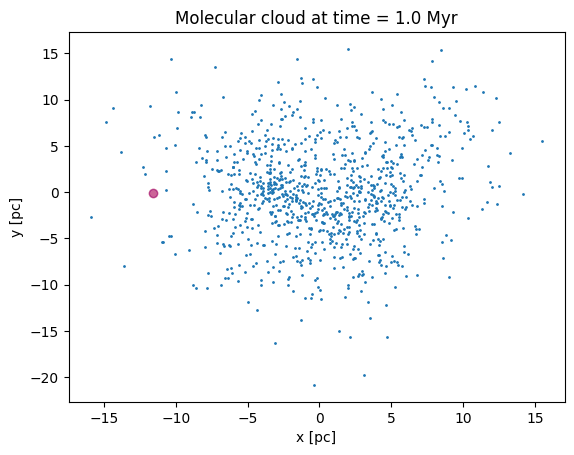

pre channel 603.626943005 MSun
post channel 603.626943005 MSun
Sink in progress at 1.5  Myr
113.989637306 MSun
954 number of cloud particles now
post accretion 613.989637306 MSun


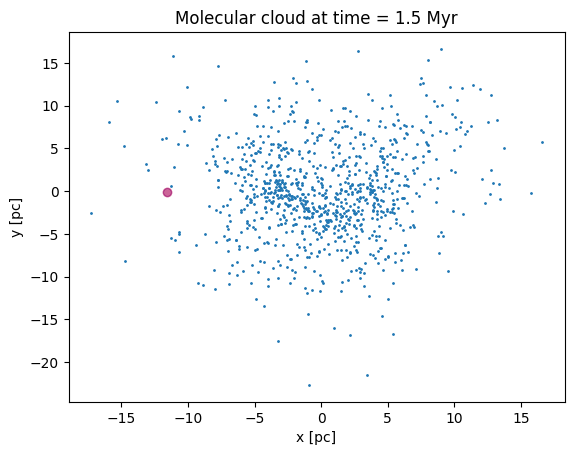

pre channel 613.989637306 MSun
post channel 613.989637306 MSun
Sink in progress at 2.0  Myr
155.440414508 MSun
950 number of cloud particles now
post accretion 655.440414508 MSun


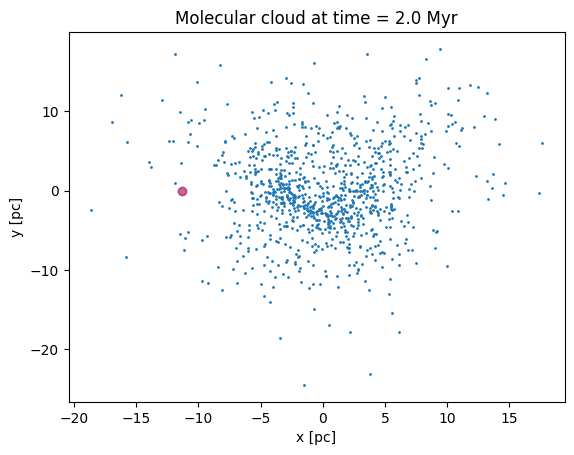

pre channel 655.440414508 MSun
post channel 655.440414508 MSun
Sink in progress at 2.5  Myr
155.440414508 MSun
950 number of cloud particles now
post accretion 655.440414508 MSun


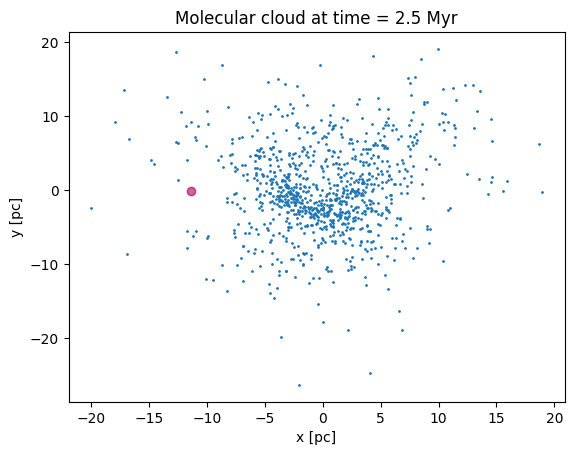

pre channel 655.440414508 MSun
post channel 655.440414508 MSun
Sink in progress at 3.0  Myr
165.803108808 MSun
949 number of cloud particles now
post accretion 665.803108808 MSun


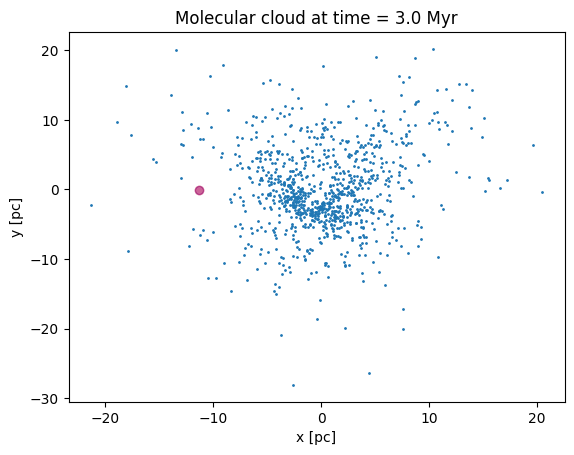

pre channel 665.803108808 MSun
post channel 665.803108808 MSun
Sink in progress at 3.5  Myr
176.165803109 MSun
948 number of cloud particles now
post accretion 676.165803109 MSun


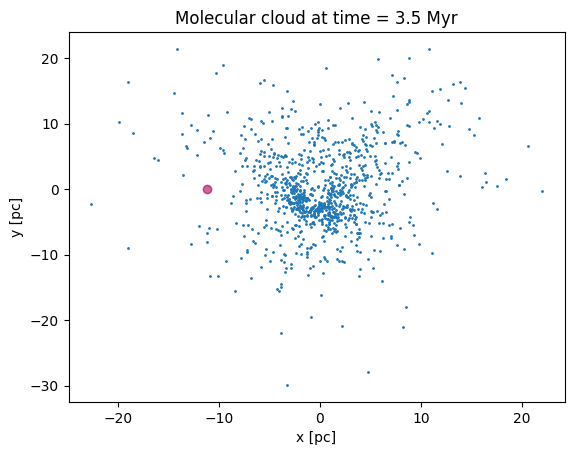

pre channel 676.165803109 MSun
post channel 676.165803109 MSun
Sink in progress at 4.0  Myr
186.528497409 MSun
947 number of cloud particles now
post accretion 686.528497409 MSun


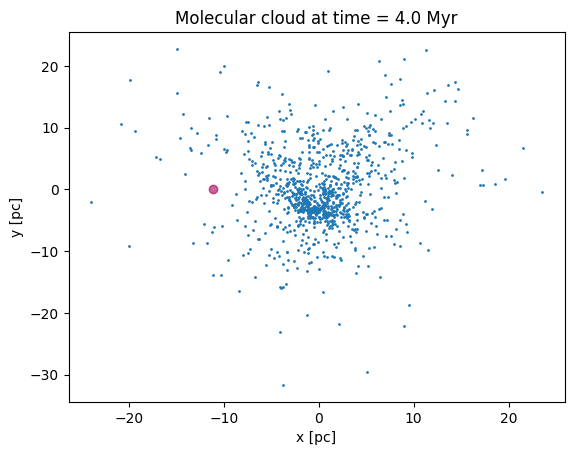

pre channel 686.528497409 MSun
post channel 686.528497409 MSun
Sink in progress at 4.5  Myr
186.528497409 MSun
947 number of cloud particles now
post accretion 686.528497409 MSun


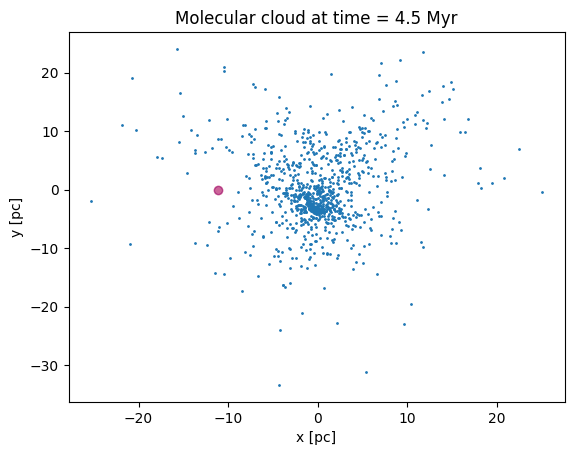

pre channel 686.528497409 MSun
post channel 686.528497409 MSun
Sink in progress at 5.0  Myr
186.528497409 MSun
947 number of cloud particles now
post accretion 686.528497409 MSun


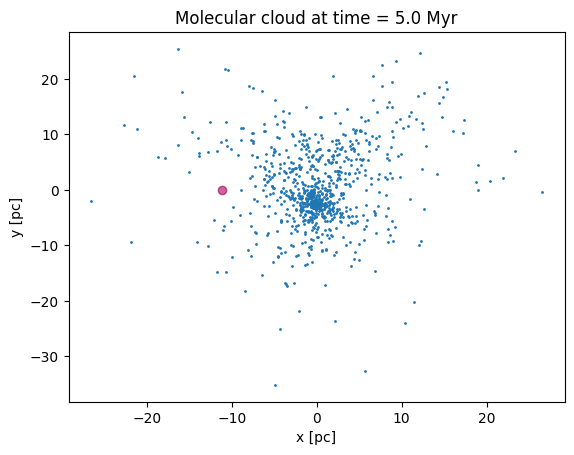

In [13]:
t_end = 5 | units.Myr
model_time = 0 | units.Myr
dt = 0.5 | units.Myr

L = int(abs(sink.position.sum().value_in(units.pc)))*1.2
N = 500
sink.sink_radius = 5 | units.pc

total_mass_loss =[]

while model_time < t_end:
    
    model_time += dt
    gravhydrobridge.evolve_model(model_time)

    print("pre channel",sink.mass[0])

    # update channels
    channel["from_sink"].copy()
    channel["to_sink"].copy()

    channel["to_cloud"].copy()
   

    print("post channel",sink.mass[0])

    print('Sink in progress at', model_time.value_in(units.Myr), ' Myr')
    
   
    #bondi_radius(sink.mass)
    sink.accrete(particles_cloud)

    dm = sink.mass[0] - initial_mass
    total_mass_loss.append(dm)

    print(dm)
    print(len(particles_cloud.mass), "number of cloud particles now")
    print("post accretion",sink.mass[0])

    plt.scatter(sink.x.value_in(units.pc), sink.y.value_in(units.pc), c = 'red', alpha=0.5)
    plt.scatter(star.x.value_in(units.pc), star.y.value_in(units.pc), c = 'blue',alpha=0.2)
    plt.scatter(particles_cloud.x.value_in(units.pc), particles_cloud.y.value_in(units.pc), s = 1)
    plt.title("Molecular cloud at time = " + model_time.as_string_in(units.Myr))
    plt.xlabel("x [pc]")
    plt.ylabel("y [pc]")
    plt.show()

  

    



In [14]:
gravity_code.stop()
hydro_cloud.stop()
gravhydrobridge.stop()

In [15]:
print(sink.mass.value_in(units.MSun))
print(star.mass)

[ 686.52849741]
[686.528497409] MSun


In [23]:
print(particles_cloud.mass.sum().value_in(units.MSun)+186)

9999.47150259


In [17]:
star.mass = 2542 |units.MSun

In [18]:
print(sink.mass)

[2542.0] MSun
